## Music Task - Whole Brain Parcellation
Data set an be obtained from: https://openneuro.org/datasets/ds000171/versions/00001

Whole brain parcellation using Power 2011

Conducted across the whole group - next steps would be to look by group

N=21 (11 controls, 10 MDD)

In [ ]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
import glob as glob
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn import plotting 
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

/usr/local/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Define some parameters
n_scans = 105
tr = 3
nr_cond = 2 #2 conditions: Positive music and Negative music
epoch_duration = 31.5 # in sec

In [4]:
# Load in data from the local directory

top_dir = '/ifshome/jaliu/Documents/Neurohackademy/nilearn_networks/openneurodata/'
fmri = glob.glob(top_dir + 'run-1/data/sub-*_task-music_run-1_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
confounds_list = glob.glob(top_dir + 'run-1/confounds/sub-*_task-music_run-1_bold_confounds.tsv')

len(confounds_list)

21

## Creating an atlas (Power)

In [5]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    smoothing_fwhm = 6, 
    radius = 5,
    detrend = True, 
    standardize = True,
    low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 3
)

parcellation = power_spheres

In [6]:
timeseries_all = np.zeros((len(fmri), n_scans, 264))

for sub in range(len(fmri)):

        sub_dir = fmri[sub]
        
        # Loading confound data
        confounds_path = confounds_list[sub]
             
        confounds = pd.read_csv(confounds_path, delimiter = '\t')

        # Select columns of interest
        confounds_filtered = confounds[confounds.filter(regex='X|Y|Z|RotX|RotY|RotZ').columns] #may want to include more

        # Save preprocessed confound file
        timeseries = parcellation.fit_transform(fmri[sub], confounds = np.array(confounds_filtered))

        timeseries_all[sub, :, :] = timeseries

In [7]:
timeseries.shape

(105, 264)

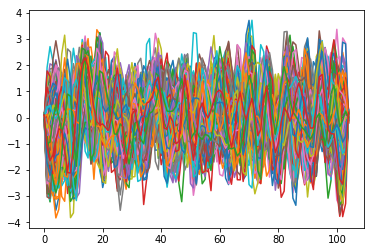

In [8]:
plt.plot(timeseries_all[1,:,:])

## Splitting into conditions

In [9]:
timeseries

array([[ 0.11221541,  0.14143983,  0.12119338, ..., -0.02018089,
         0.02305113,  0.06348784],
       [-1.9384813 , -1.4510114 ,  0.06286265, ...,  0.7086041 ,
         2.0548549 , -0.81644696],
       [-3.4924445 , -2.7220068 ,  0.14215073, ...,  0.27071756,
         2.31382   , -1.1895131 ],
       ...,
       [ 0.9237466 ,  0.21097745, -0.32363006, ...,  1.6419902 ,
        -1.6777129 , -0.5167087 ],
       [ 0.71234035,  0.4880214 ,  0.13792694, ...,  1.6489947 ,
        -1.7455373 , -0.55061275],
       [ 0.16422077,  0.11379868, -0.08223793, ...,  0.10176067,
         0.08090697,  0.02243212]], dtype=float32)

In [10]:
# Load in event timing file

cond_path = top_dir + 'sub-control01_func_sub-control01_task-music_run-1_events.tsv'
conditions = pd.read_csv(cond_path, sep='\t')

conditions

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [11]:
np.asarray(conditions.onset[conditions['trial_type'] == 'negative_music'])

array([ 36., 174.])

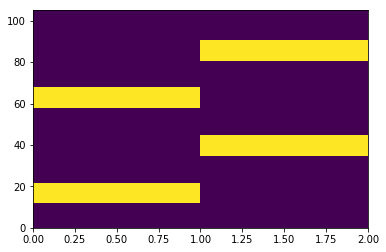

In [12]:
# Create a boolean array denoting the timing for different music conditions

onsets_negative_music = np.asarray(conditions.onset[conditions['trial_type'] == 'negative_music'])
onsets_positive_music = np.asarray(conditions.onset[conditions['trial_type'] == 'positive_music'])

music = np.zeros((n_scans, nr_cond))
for i in range(len(music)):
    if i in onsets_negative_music/tr:
        for k in range(int(epoch_duration/tr)):
            music[i + k, 0] = 1
    if i in onsets_positive_music/tr:
        for k in range(int(epoch_duration/tr)):
            music[i + k, 1] = 1
            
music = music.astype(bool)     
plt.pcolormesh(music)
plt.show()

In [13]:
negative_music = timeseries_all[:, music[:, 0], :]
positive_music = timeseries_all[:, music[:, 1], :]

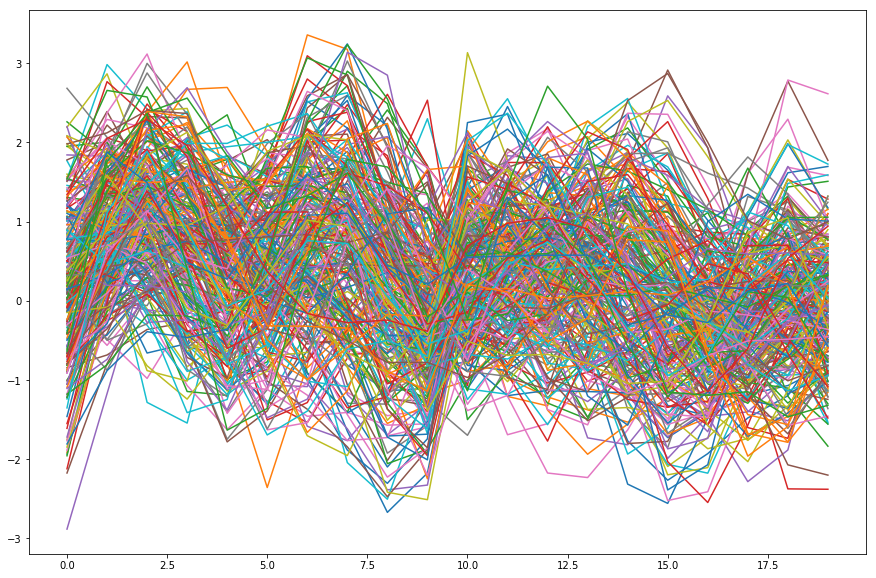

In [14]:
plt.figure(figsize = (15, 10))
_ = plt.plot(negative_music[1,:,:])

In [15]:
negative_music.shape

(21, 20, 264)

In [16]:
#Make some correlation matrices

sub_n = len(timeseries_all[:, 0, 0])
cond_n = nr_cond
rois_n = len(timeseries_all[0, 0, : ])

correlation_matrices = np.zeros((sub_n, cond_n, rois_n, rois_n))

for sub in range(sub_n):  
    
    negative_music = timeseries_all[sub, music[:, 0], :]
    positive_music = timeseries_all[sub, music[:, 1], :]
        
    correlation_measure = ConnectivityMeasure(kind = 'correlation')
    
    fc1 = correlation_measure.fit_transform([negative_music])[0]
    np.fill_diagonal(fc1, 0)
        
    fc2 = correlation_measure.fit_transform([positive_music])[0]
    np.fill_diagonal(fc2, 0)
                              
    correlation_matrices[sub, 0, :, :] = fc1
    correlation_matrices[sub, 1, :, :] = fc2
    
correlation_matrices.shape

(21, 2, 264, 264)

In [17]:
negative_music_mean = correlation_matrices[:, 0, :, :].mean(axis = 0)
positive_music_mean = correlation_matrices[:, 1, :, :].mean(axis = 0)

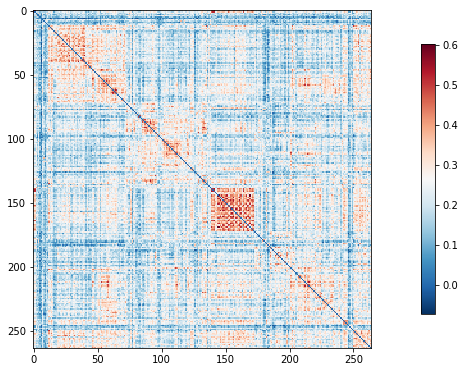

In [18]:
plotting.plot_matrix(negative_music_mean)

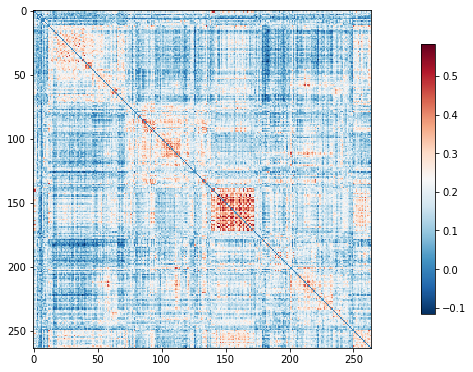

In [19]:
plotting.plot_matrix(positive_music_mean)

In [20]:
from scipy import stats
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix

negative_music = sym_matrix_to_vec(correlation_matrices[:, 0, :, :], discard_diagonal = True)
positive_music = sym_matrix_to_vec(correlation_matrices[:, 1, :, :], discard_diagonal = True)

In [21]:
stat, pvalues = stats.ttest_rel(negative_music, positive_music)

In [22]:
import statsmodels.stats.multitest as ssm

_, pvals_corrected, _, _ = ssm.multipletests(pvalues, alpha = 0.05, method = 'fdr_bh')

pvals_corrected_thr = np.zeros((len(pvals_corrected)))

pvals = np.array([0 if p >= 0.08 else 1 for p in pvals_corrected])


wei_vector = stat * pvals 
diag = np.zeros((264))
matrix = vec_to_sym_matrix(wei_vector, diagonal = diag)
#matrix = vec_to_sym_matrix(pvals_corrected)

matrix_bin = vec_to_sym_matrix(pvals, diagonal = diag)

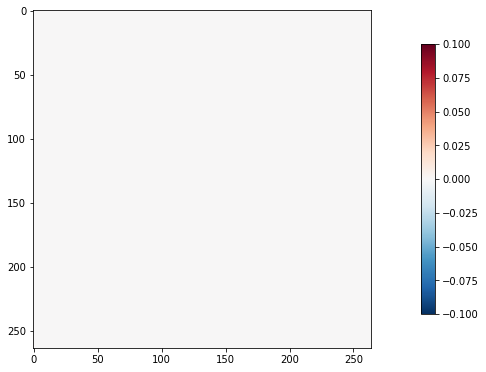

In [23]:
plotting.plot_matrix(matrix_bin)

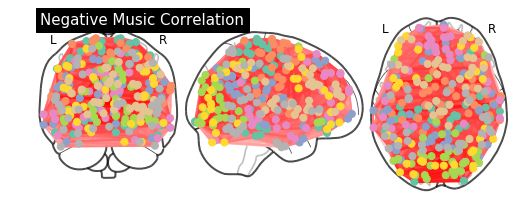

In [24]:
from nilearn import plotting

plotting.plot_connectome(negative_music_mean, power_coords,
                         title='Negative Music Correlation')

In [ ]:
from nilearn import plotting

plotting.plot_connectome(positive_music_mean, power_coords,
                         title='Positive Music Correlation')